Загрузка библиотек

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Импорт файла с данными для сравнения:

In [105]:
exp = pd.read_csv('EngineSem.ind', encoding='latin-1', header=None, skiprows = 19, delimiter='\s+')
exp.columns = ['Fi', 'Pc', 'Tc', 'Vc', 'Alf_w', 'P_1ring', 'G_bb', 'P_pist', 'x']
exp = exp[['Fi', 'Pc', 'Tc', 'x']]
exp['Pc'] = exp['Pc']*10**5
exp.head(5)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\rodio\AppData\Local\Temp\ipykernel_5708\963133964.py:1: SyntaxWarning: invalid escape sequence '\s'
  exp = pd.read_csv('EngineSem.ind', encoding='latin-1', header=None, skiprows = 19, delimiter='\s+')


,Fi,Pc,Tc,x
0,180.0,193000.0,346.4,2.000000e+25
1,181.0,193000.0,346.5,2.000000e+25
2,182.0,193000.0,346.6,2.000000e+25
3,183.0,193000.0,346.7,2.000000e+25
4,184.0,193000.0,346.8,2.000000e+25


# Исходные данные по двигателю

### Геометрические параметры двигателя

In [106]:
D=0.102          # диаметр цилиндра, м
S=0.122          # ход поршня, м
n_mex=0.82956    # механический КПД
n=2400           # частота вращения, об/мин
icyl=6           # кол-во цилиндров
eps=18           # степень сжатия
lamb=0.264       # R/L
qc  = 7.05e-05  # Цикловая подача
Hu = 42.5*10**6

### Прочие константы

In [107]:
Rm=8.314          # Универсальная газовая постоянная
dFi=np.pi/180     # Приращение угла поворота КВ
N=900             # Статическое количество элементов в массивах

# Функции

### Объем КС как функция угла поворота коленчатого вала:
$$ V(\phi) = V_c + V_h -\frac{\pi D^2} 4 \frac{S} 2 ((1 - cos (\phi))-\frac{\lambda} 4 (1 -cos(2\phi)))$$

In [108]:
def Vol(deg):
    Ap = np.pi * D ** 2 / 4
    Vh = Ap * S
    Vc = Vh / (eps - 1)
    V = Vc + Vh - Ap * S / 2 * (1 - np.cos(np.deg2rad(deg)) - lamb / 4 * (1 - np.cos(2*np.deg2rad(deg))))
    return V

### Термодинамическая работа
$$ \frac{dL} {d\phi} = -p\frac{dV}{d\phi} $$

In [109]:
def dL(P, Fi):
    dl = -P * (Vol(Fi+1) - Vol(Fi))/dFi
    return dl

### Теплообмен с окружающими деталями КС:
$$ \frac{dQ_w} {d\phi} = \qquad \sum_{i=1}^3 \alpha_w(T-T_w^i)F_i \frac{dt}{d\omega} $$
Площадь крышки цилиндра:
$$ F_k = \frac{\pi D^2} 4 $$
Площадь поршня:
$$ F_p = 1.4 F_k $$
Площадь гильзы:
$$ F_{cyl}(\phi) = {\pi D}(\delta + S_p(\phi)) $$
Коэффициент теплоотдачи по формуле Г. Эйхельберга:
$$ \alpha_w(\phi) = 77.9 \cdot 10^{-4} C_m^{\frac 1 3} \sqrt{PT} $$

In [110]:
def dQw(P, T, Fi):
    delta = 0.005
    T_h = 473
    T_cyl = 420
    T_p = 521
    Cm = S * n / 30
    Fpist = np.pi*D**2/4
    Vh = Fpist * S
    Vc = Vh / (eps - 1)
    Fcyl = ((Vol(Fi) - Vc) / Fpist + delta) * np.pi * D
    alfa_w =77.9 * 10 ** (-4) * Cm ** (1 / 3) * np.sqrt(P * T)
    dQh = alfa_w * (T - T_h) * 1.4 * Fpist
    dQcyl = alfa_w * (T - T_cyl) * Fcyl
    dQp = alfa_w * (T - T_p) * Fpist
    dqw = -(dQp + dQcyl + dQh) / (np.pi * n / 30)
    return dqw

# Основная программа

### Получение данных о характеристике тепловыделения

Пусть пока теплоемкость будет 25

In [111]:
cv = 25

Определим слагаемые для Первого Закона Термодинамики


$$ \dfrac{dQ_{сг}} {d\phi} = \dfrac{dU} {d\phi} - \dfrac{dL} {d\phi} - \dfrac{dQ_w} {d\phi} $$
$$ \dfrac{dU} {d\phi} = C_v\dfrac{d(MT)} {d\phi}  \quad | pV = MRT | \quad = \frac{C_v}{R_m}\dfrac{d(pV)} {d\phi}$$ 
$$ \frac{dL} {d\phi} = -p\frac{dV}{d\phi} $$
$$ \frac{dQ_w} {d\phi} = \qquad \sum_{i=1}^3 \alpha_w(T-T_w^i)F_i \frac{dt}{d\omega} $$
Тогда формула для тепла выделившегося при сгорании примет вид:
$$ \dfrac{dQ_{сг}} {d\phi} = (\frac{C_v}{R_m}+1)p\frac{dV}{d\phi} + \frac{C_v}{R_m}V\frac{dp}{d\phi} -\dfrac{dQ_w} {d\phi}  $$

In [112]:
## написать цикл для определения  dQc по углу поворота КВ
def dQc(Fi):
    return (cv/Rm +1)*exp['Pc'][Fi]*(Vol(Fi)-Vol(Fi-1))/dFi+cv/Rm*Vol(Fi)*(exp['Pc'][Fi]-exp['Pc'][Fi-1])/ dFi - dQw(exp['Tc'][Fi], exp['Tc'][Fi],Fi) 

График тепла   $ \dfrac{dQ_{сг}} {d\phi} $ от угла поворота КВ

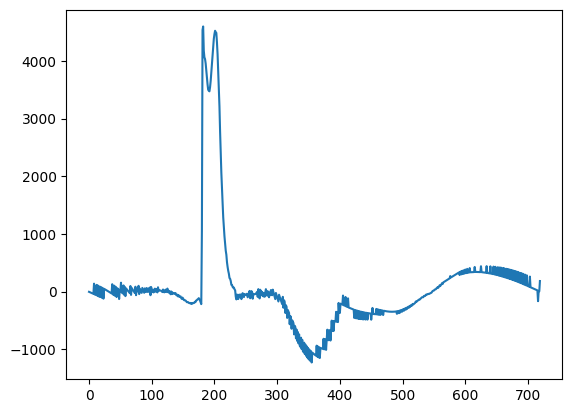

In [113]:
plt.plot([dQc(Fi) for Fi in range(1, 721)])

Скорость тепловыделения:
$$ \dfrac{dQ_{сг}} {d\phi} = Hu\dfrac{dx} {d\phi}q_c $$

График тепла   $ \dfrac{dx} {d\phi} $ от угла поворота КВ

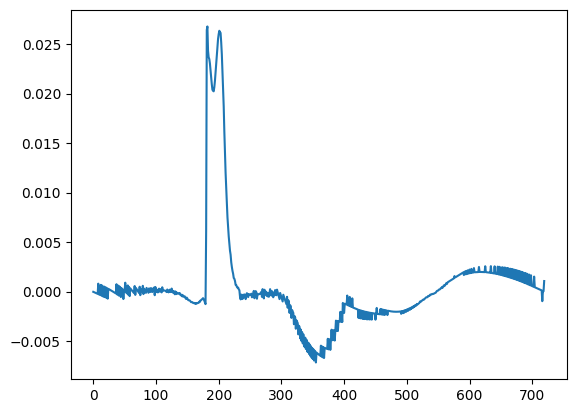

In [114]:
plt.plot([dQc(Fi) / Hu / qc * dFi for Fi in range(1, 721)])

0.7622930315965369


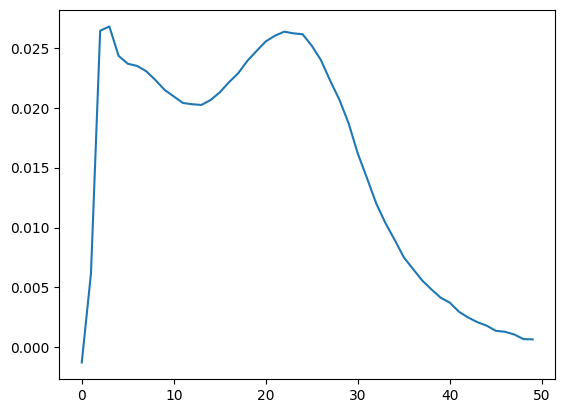

In [115]:
## отобразить на графике dXdFi (как dQcdFi/Hu/qc ) по углу поворота КВ
dx_exp = [dQc(Fi) / Hu / qc * dFi for Fi in range(180,230)]
plt.plot(dx_exp)

sum = 0

for Fi in range(180, 240):
    sum += dQc(Fi) / Hu / qc * dFi
print(sum)


Необходимо на интервале, где происходит сгорание - записать dXdFi в отдельную переменную

In [116]:
# отдельно записать в переменную участок dXdFi по углу поворота КВ от начала сгорания
# np.float64(dx_exp)
# result = sum(dx_exp)


In [117]:
## отобразить на графике dXdFi  по углу поворота КВ

### Использование формулы Вибе для моделирования сгорания

Для дизельного двигателя можно записать с следующим виде:
$$ \dfrac{dx_{диз}} {d\phi} =  \dfrac{dx_{об}} {d\phi} + \dfrac{dx_{диф}} {d\phi} $$
Для объемного сгорания:
$$ \dfrac{dx_{об}} {d\phi} =\chi_t [\frac{m_t}{\phi_{сг}}][\frac{\phi}{\phi_{сг}}]exp(-\frac{m_t}{m_t+1}[\frac{\phi}{\phi_{сг}}]^{m_t+1})$$
Для диффузионного сгорания:
$$ \dfrac{dx_{диф}} {d\phi} = (1-\chi_t) C [\frac{m_v+1}{\phi_{z}}][\frac{\phi}{\phi_{z}}]exp(-C[\frac{\phi}{\phi_{z}}]^{m_v+1})$$
$ \chi_t $ - доля топлива сгоревшего по кинетическому механизму;

$ m_t $ - показатель кинетического сгорания;

$ \phi_{сг} $ - угол максимального скорости кинетического сгорания;

$ m_v $ - показатель объемного сгорания;

$ С = -ln[1-\Delta x] $ 

$\Delta x $ - доля сгоревшего топлива за весь процесс (обычно принимается ~0.99);

$ \phi_{z} $ - полная продолжительность процесса сгорания.

Необходимо подобрать константы (кроме тех, что можно "взять с графика")

In [118]:
# записать выражения для констант в Формуле Вибе
ksi = 0.1
dx = 0.99
mt = 1
mv = 1
Fiz = 80
n_count = Fiz
Fic = 4
C = -np.log(1-dx)

Записать функцию для определения скорости тепловыделения

In [119]:
## def функция по углу поворота - и ее скинуть в основной файл - попозже !
def funcdxdf(Fi, ksi, mt, mv, Fiz, Fic):
    dxob = ksi * (mt / Fic) * (Fi / Fic) * np.exp(-mt / (mt + 1) * (Fi / Fic)**(mt + 1))
    dxdif = (1 - ksi) * C * (mv + 1) / Fiz * (Fi / Fiz) * np.exp(-C * (Fi / Fiz) ** (mv + 1))
    return dxob + dxdif

In [120]:
Fi = np.linspace(0, Fiz, n_count)
# создать переменную и используя функция записать значения скорости тепловыделения по углу поворота КВ
dxdfi = funcdxdf(Fi, ksi, mt, mv, Fiz, Fic)

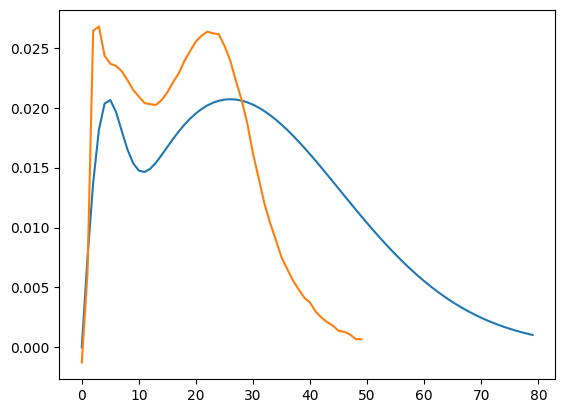

In [122]:
## Отобразить и сравнить получившиеся значения скорости тепловыделения
plt.plot(dxdfi)
plt.plot(dx_exp)